# Inference from Torch of angiograms   



In [1]:
1+1

2

In [4]:
import torch
import torch.nn as nn
import onnx
import dill as pickle
import os
import matplotlib.pyplot as plt  # Add this line

In [5]:
torch.__version__

'2.5.1'

In [6]:
# Check if running on Mac OS
is_mac = os.name == 'posix' and os.uname().sysname == 'Darwin'
print('posix' if os.name == 'posix' else 'not posix')
print('mac' if is_mac else 'not mac')


posix
mac


In [7]:
# Set up paths
is_mac = os.name == 'posix' and os.uname().sysname == 'Darwin'
rootPath = "~/Projects/AWI/NetExploration/" if is_mac else '/mnt/SliskiDrive/AWI/AWIBuffer/' # '/Volumes/Crucial X8/AWIBuffer/'


In [8]:
rootPath

'~/Projects/AWI/NetExploration/'

In [9]:
# model_path = "/home/ubuntu/U-Mamba-Adjustment/data/nets/UXlstmBot-nnUNetPlans_2d-DC_and_CE_loss-w-1-20-20-dill.pth"
model_path = rootPath + "UXlstmBot-nnUNetPlans_2d-DC_and_CE_loss-w-1-20-20-dill.pth"
model_path = "/Users/billb/Projects/AWI/NetExploration/UXlstmBot-nnUNetPlans_2d-DC_and_CE_loss-w-1-20-20-dill.pth"


In [10]:
model_path

'/Users/billb/Projects/AWI/NetExploration/UXlstmBot-nnUNetPlans_2d-DC_and_CE_loss-w-1-20-20-dill.pth'

In [11]:
# Set up device
gpuDevice = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {gpuDevice}") 

Using device: mps


In [12]:
import sys
sys.path.append("/Users/billb/github/nnUNet-Adjustment")

In [13]:
import nnunetv2

In [14]:
# !pip install blosc2

In [ ]:
model = torch.load(model_path, pickle_module=pickle, map_location=gpuDevice)
# model.to(gpuDevice)
model.eval()

UXlstmBot(
  (encoder): UNetResEncoder(
    (stem): Sequential(
      (0): BasicResBlock(
        (conv1): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (act1): LeakyReLU(negative_slope=0.01, inplace=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (act2): LeakyReLU(negative_slope=0.01, inplace=True)
        (conv3): Conv2d(5, 32, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): BasicBlockD(
        (conv1): ConvDropoutNormReLU(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (nonlin): LeakyReLU(negative_slope=0.01, inplace=True)
          (all_modules): Sequentia

## Test Model with HDF5 Input

In [18]:
import platform

system = platform.system()
if "Darwin" in system:
    if os.path.isdir("/Volumes/Crucial X8"):
        dataDir = "/Volumes/Crucial X8/AWIBuffer"
    else:
        dataDir = "/Users/billb/Projects/AWI/NetExploration"
elif "Linux" in system:
    dataDir = "/mnt/SliskiDrive/AWI/AWIBuffer"
else:
    dataDir = None  # or some default path

# dataDir = "/home/ubuntu/data"
angiogramH5Path = dataDir + "/AngiogramsDistilledUInt8List.h5"
angiogramH5Path

'/Volumes/Crucial X8/AWIBuffer/AngiogramsDistilledUInt8List.h5'

In [20]:
import h5py

# Open the HDF5 file and print all dataset keys
with h5py.File(angiogramH5Path, 'r') as f:
    # Get all keys at root level
    keys = list(f.keys())
    print("Dataset keys in HDF5 file:")
    for key in keys:
        print(f"- {key}")


Dataset keys in HDF5 file:
- Angios_001_rev
- Angios_005_rev
- Angios_006_rev
- Angios_007_rev
- Angios_008_rev
- Angios_013_rev
- Angios_015_rev
- Angios_016_rev
- Angios_021_rev
- Angios_022_rev
- Angios_030_rev
- Angios_031_rev
- Angios_032_rev
- Angios_048
- Angios_051_rev
- Angios_053_rev
- Angios_057_rev
- Angios_061
- Angios_063_rev
- Angios_064_rev
- Angios_065_rev
- Angios_067_rev
- Angios_072_rev
- Angios_075_rev
- Angios_079_rev
- Angios_081_rev
- Angios_082_rev
- Angios_097_rev
- Angios_104_rev
- Angios_112_rev
- Angios_114_rev
- Angios_120_rev
- Angios_128_rev
- Angios_129_rev
- Angios_133_rev
- Angios_148_rev
- Angios_157_rev
- Angios_161_rev
- Angios_164_rev
- Angios_168_rev
- Angios_170_rev
- Angios_181_rev
- Angios_190_rev
- Angios_191_rev
- Angios_197_rev
- Angios_198_rev
- Napari_053_rev
- Napari_0_rev
- Napari_100_rev
- Napari_101_rev
- Napari_10_rev
- Napari_12_rev
- Napari_13_rev
- Napari_14_rev
- Napari_15_rev
- Napari_16_rev
- Napari_17_rev
- Napari_18_rev
- Nap

In [21]:
# Load first angiogram from HDF5 file
import random
with h5py.File(angiogramH5Path, 'r') as f:
    # Get first key
    hdfKey = random.choice(keys)
    print(f"Loading dataset: {hdfKey}")
    # Load data into tensor
    agram = torch.from_numpy(f[hdfKey][:]).float()
    print(f"Loaded tensor shape: {agram.shape}")


Loading dataset: Napari_44_rev
Loaded tensor shape: torch.Size([36, 512, 512])


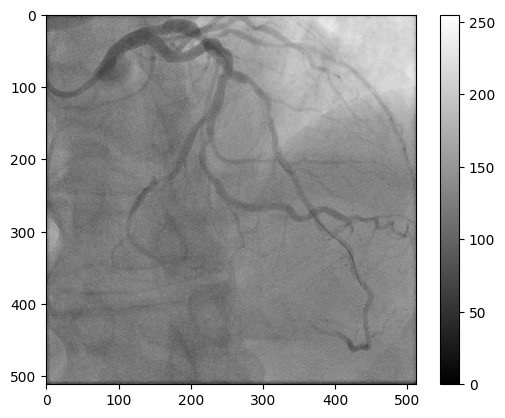

In [22]:
#Display the 30th frame of the angiogram
plt.imshow(agram[30], cmap='gray')
plt.colorbar()
plt.show()


In [23]:
# Normalize angiogram by subtracting mean and dividing by standard deviation
xagram = (agram - agram.mean()) / agram.std()
print(f"Normalized tensor shape: {xagram.shape}")


Normalized tensor shape: torch.Size([36, 512, 512])


In [24]:
# Create input tensor with 5 consecutive frames centered around frame 30
start_idx = 28  # 30-2 to get 2 frames before
end_idx = 33    # 30+3 to get 2 frames after (exclusive)
z = xagram[start_idx:end_idx].unsqueeze(0)  # Add batch dimension
print(f"Input tensor shape: {z.shape}")


Input tensor shape: torch.Size([1, 5, 512, 512])


In [25]:
# Move model and input tensor to GPU device
# gpuDevice = 'mps'
model = model.to(gpuDevice)
z = z.to(gpuDevice)


In [26]:
with torch.no_grad():
    model.eval()
    y = model(z)


In [27]:
# Apply softmax along dimension 1 (second dimension) which has size 3
y = torch.nn.functional.softmax(y, dim=1)
print(f"Output tensor shape after softmax: {y.shape}")


Output tensor shape after softmax: torch.Size([1, 3, 512, 512])


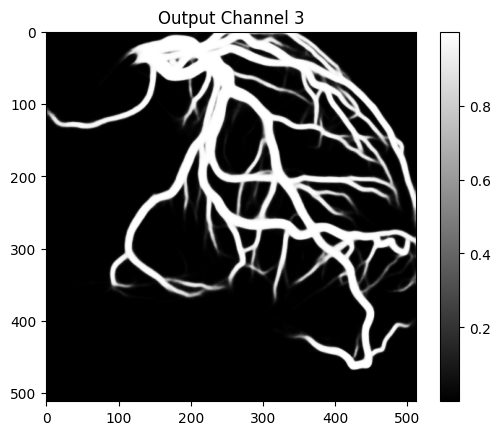

In [28]:
# Display the 3rd channel (index 2) of the output
plt.imshow(y[0, 2].cpu().detach().numpy(), cmap='gray')
plt.colorbar()
plt.title('Output Channel 3')
plt.show()


In [29]:
# Calculate number of valid frame groups (each group has 5 consecutive frames)
num_frames = xagram.shape[0]
num_groups = num_frames - 4  # Each group needs 5 frames

# Create tensor to hold all valid frame groups
z5 = torch.zeros((num_groups, 5, 512, 512))

# Fill z5 with overlapping groups of 5 consecutive frames
for i in range(num_groups):
    z5[i] = xagram[i:i+5]

print(f"Shape of tensor containing all valid 5-frame groups: {z5.shape}")


Shape of tensor containing all valid 5-frame groups: torch.Size([32, 5, 512, 512])


In [30]:
# Get the middle 10 frames from z5
middle_idx = z5.shape[0] // 2  # Find middle index
start_idx = middle_idx - 5    # 10 frames before middle
end_idx = middle_idx + 5      # 10 frames after middle
z5 = z5[start_idx:end_idx]     # Keep only middle 20 frames

print(f"Shape of tensor after selecting middle 20 frames: {z5.shape}")


Shape of tensor after selecting middle 20 frames: torch.Size([10, 5, 512, 512])


In [31]:
# Feed z5 into the model and get the output
model = model.to(gpuDevice)
z5 = z5.to(gpuDevice)

with torch.no_grad():
    model.eval()
    y5 = model(z5)


In [32]:
y5.shape

torch.Size([10, 3, 512, 512])

In [33]:
# Apply softmax along dimension 1 (second dimension) which has size 3
ys5 = torch.nn.functional.softmax(y5, dim=1)
print(f"Output tensor shape after softmax: {ys5.shape}")


Output tensor shape after softmax: torch.Size([10, 3, 512, 512])


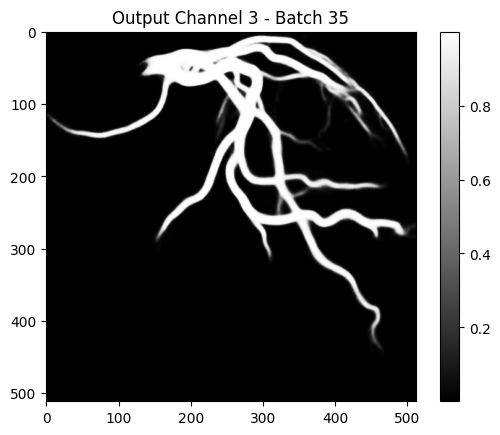

In [34]:
# Display the 3rd channel (index 2) of batch member 35
plt.imshow(ys5[5, 2].cpu().detach().numpy(), cmap='gray')
plt.colorbar()
plt.title('Output Channel 3 - Batch 35')
plt.show()


## Export Back to ONNX

# Export model back to ONNX
onnxOutputPath = model_path.replace(".pth", ".onnx")


In [35]:
# Export model back to ONNX
onnxOutputPath = model_path.replace(".pth", ".onnx")

In [ ]:

# Move both model and input tensor to CPU for export
# model_for_export = modelPerOnnx.to(gpuDevice)
# input_for_export = z5.to(gpuDevice)

# with torch.inference_mode():
#     torch.onnx.export(model,
#                      z,
#                      onnxOutputPath, 
#                      export_params=True,
#                      #opset_version=18, 
#                      do_constant_folding=True,
#                      verbose=True,
#                      input_names=['input'],
#                      output_names=['output'], 
#                      dynamic_axes={'input': {0: 'batch_size'}, 
#                                  'output': {0: 'batch_size'}}, 
#                      training=torch.onnx.TrainingMode.EVAL)
torch.onnx.export(model,
                     z,
                     onnxOutputPath, 
                     export_params=True,
                     #opset_version=18, 
                     do_constant_folding=True,
                     verbose=True)



/Users/billb/github/nnUNet-Adjustment/nnunetv2/nets/UxLSTMBot_2d.py:55: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert C == self.dim
/Users/billb/github/nnUNet-Adjustment/nnunetv2/nets/vision_lstm.py:83: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if lower_triangular_matrix is None or S < lower_triangular_matrix.size(-1):
/Users/billb/github/nnUNet-Adjustment/nnunetv2/nets/vision_lstm.py:118: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value 

In [ ]:
# onnx_program = torch.onnx.export(model, z, dynamo=True)
onnx_program = torch.onnx.dynamo_export(model, z)

In [ ]:
# with torch.inference_mode():
#     onnx_program = torch.onnx.dynamo_export(model,
#                      z, 
#                      export_params=True,
#                      #opset_version=18, 
#                      do_constant_folding=True,
#                      verbose=True,
#                      input_names=['input'],
#                      output_names=['output'], 
#                      dynamic_axes={'input': {0: 'batch_size'}, 
#                                  'output': {0: 'batch_size'}}, 
#                      training=torch.onnx.TrainingMode.EVAL)

In [29]:
onnx_program.save(onnxOutputPath)

## Save and Load PyTorch Model

In [ ]:
# Save PyTorch model
torchModelPath = onnxPath.replace(".onnx", "-torch-onnx.pt")
torch.save(modelPerOnnx, torchModelPath)

# Load and verify
checkModel = torch.load(torchModelPath, weights_only=False)
checkModel.eval()
with torch.inference_mode():
    result = checkModel(random_tensor)

print("Verification output shape:", result.shape)

## TorchScript Conversion

In [ ]:
# Create example inputs with different batch sizes
example_input_1 = torch.randn(2, 5, 512, 512).to(gpuDevice)
example_input_2 = torch.randn(4, 5, 512, 512).to(gpuDevice)

# Create traced model
tracedModel = torch.jit.trace(model, example_input_1, check_trace=False)

# Save traced model
# tracedModelPath = model_path.replace(".pth", "-torchscript-traced-onnx.pt")
# tracedModelperOnnx.save(tracedModelPath)

## Verify Traced Model

In [ ]:
# Load and test traced model
# tracedModel = torch.jit.load(tracedModelPath)
tracedModel = tracedModel.to(gpuDevice)

tracedModel.eval()
with torch.inference_mode():
    result = tracedModel(z5)

print("Traced model output shape:", result.shape)

# Test with different batch size
# result = tracedModelperOnnx(example_input_2)
# print("Different batch size output shape:", result.shape)

In [ ]:
# Export model back to ONNX
onnxOutputPath = model_path.replace(".pth", ".onnx")
onnxOutputPath

In [ ]:
torch.onnx.export(tracedModel,
                     z,
                     onnxOutputPath, 
                     export_params=True,
                     #opset_version=18, 
                     do_constant_folding=True,
                     verbose=True)

In [ ]:
from typing import Tuple
import torch

def get_torch_cuda_versions() -> Tuple[str, str, bool]:
    """
    Get PyTorch and CUDA versions along with CUDA availability status.

    Returns
    -------
    Tuple[str, str, bool]
        A tuple containing:
        - PyTorch version (str)
        - CUDA version (str) if available, 'N/A' if not
        - CUDA availability status (bool)
    """
    torch_version = torch.__version__
    cuda_available = torch.cuda.is_available()
    cuda_version = torch.version.cuda if cuda_available else "N/A"
    
    return torch_version, cuda_version, cuda_available

def print_versions() -> None:
    """
    Print PyTorch and CUDA version information to console.
    """
    torch_version, cuda_version, cuda_available = get_torch_cuda_versions()
    
    print(f"PyTorch Version: {torch_version}")
    print(f"CUDA Available: {cuda_available}")
    print(f"CUDA Version: {cuda_version}")

if __name__ == "__main__":
    print_versions()